# Lab 2: Convolutional Neural Network
在這個Lab中，我們要利用Deep Network來訓練出一個貓狗分類器。

# 準備資料

在做這個分類器之前，請先將train.zip解壓縮。 解壓縮之後，會有很多貓的圖片和狗的圖片。 貓的圖片是以cat開頭，狗的圖片是以dog開頭。

請創立一個資料夾，資料夾的結構如下：



*   將2000張貓(狗)的圖片移至 data/train/cats (data/train/dogs)
*   將1000張貓(狗)的圖片移至 data/validation/cats (data/validation/dogs)
*   將1000張貓(狗)的圖片移至 data/test/cats (data/test/dogs)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/test/cats/cat.151.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/test/cats/cat.152.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Import Library
我們載入必要的library：

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [ ]:
from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
#from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.applications import VGG16
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import backend as K
from vis.utils import utils
from keras import activations
#from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter


#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# Utility Functions
我們以下會用視覺化的工具來幫助各位了解分類的結果。因此在這邊我們這邊先撰寫幾個utility function。函數的名字應該很好了解其功用，因此建議你可以直接看一下其功能後，就往下一個部分前進。

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# 參數設定
因為圖片的大小是150 x 150，所以我們設定圖片的長和寬。 並且設定train和validation的目錄。

In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# Data Generator
Keras針對圖片數量不夠多的問題，也提供了解法：利用ImageDataGenerator，我們可以利用一張圖片，進行若干運算之後，得到不同的圖片。 有興趣的同學可以參考：https://zhuanlan.zhihu.com/p/30197320

In [ ]:
#會出現錯誤找不到data/train，直接指定到雲端資料夾
import os
os.chdir("/content/drive/MyDrive")
#!ls

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=10,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=10,
    class_mode='binary')

Found 202 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


我們可以利用以下的code來看看結果：

In [ ]:
#from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

i = 0
for batch in datagen.flow(x, batch_size=1,save_to_dir='data', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

檢查在data/資料夾下的檔案，會發現這個generator利用了cats.0.jpg產生了很多圖片

# Building a Convolutional Neural Network
在此處，我們要建立一個CNN。

這邊有四個運算我們沒看過的：

* Conv2D: 這個函數會建立一個convolutional layer。第一個參數為filter數量，第二個是filter size。也可以在此設定padding參數為same (有padding) or valid (沒有padding)。參數Stride預設則為1。
* Activation: 用來單一增加activation function之用。
* MaxPooling2D: 建立一個maxpooling layer。參數為window size。
* Flatten: 將目前的輸出攤平成一個一維向量。
* Dropout: 執行dropout將某些點丟棄，參數為其比率。

以下我們要建立如此的network

1. CONV: 32個filter，每一個filter大小為3x3，activation function為relu
2. POOL: window size為2x2
3. CONV: 32個filter，每一個filter大小為3x3，activation function為relu
4. POOL: window size為2x2
5. CONV: 64個filter，每一個filter大小為3x3，activation function為relu
6. POOL: window size為2x2
7. FC: 64個node的full connected layer
8. Output Layer: 這是一個[ ]分類問題，所以output layer的neuron數為:[ ]，要用的激活函數為:[ ]

注意，在convolution進入到full connected layer的時候，記得要把向量攤平。

In [ ]:
#nb_train_samples = 2000
#nb_validation_samples = 800
#epochs = 50
#batch_size = 10

In [ ]:
# 判斷RGB是在矩陣中的第幾個元素?
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
metrics=['accuracy'])

# Training
因為我們準備的training data和validation data都是利用generator的形式，因此我們在指定

In [ ]:
history = model.fit(train_generator, epochs=7, validation_data=validation_generator, verbose=1)

Epoch 1/7
21/21 [==============================] - 85s 4s/step - loss: 0.7781 - accuracy: 0.5495 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 2/7
21/21 [==============================] - 2s 107ms/step - loss: 0.6937 - accuracy: 0.5495 - val_loss: 0.7018 - val_accuracy: 0.5000
Epoch 3/7
21/21 [==============================] - 2s 108ms/step - loss: 0.7658 - accuracy: 0.5644 - val_loss: 0.7025 - val_accuracy: 0.5200
Epoch 4/7
21/21 [==============================] - 2s 110ms/step - loss: 0.6899 - accuracy: 0.5842 - val_loss: 0.6835 - val_accuracy: 0.5000
Epoch 5/7
21/21 [==============================] - 2s 106ms/step - loss: 0.6936 - accuracy: 0.5891 - val_loss: 0.6903 - val_accuracy: 0.6900
Epoch 6/7
21/21 [==============================] - 2s 106ms/step - loss: 0.6789 - accuracy: 0.6089 - val_loss: 0.6591 - val_accuracy: 0.7400
Epoch 7/7
21/21 [==============================] - 2s 107ms/step - loss: 0.6642 - accuracy: 0.6238 - val_loss: 0.6859 - val_accuracy: 0.5800


我們可以利用model.save()這個函數，將model存起來供以後使用。

In [ ]:
model.save('model.h5')
save_history(history, 'history.bin')

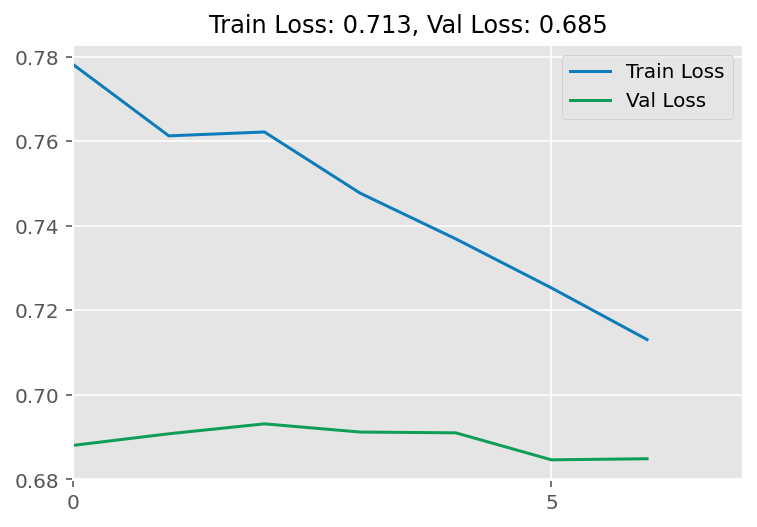

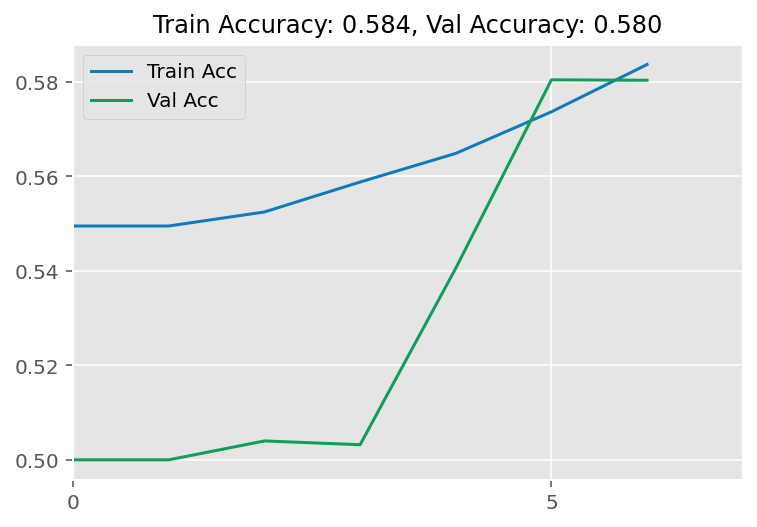

In [ ]:
history = load_history('history.bin')
plot_compare(history)

# Quiz 1: 參數數量
請問我們用手刻的CNN總共的參數數量有幾個？

可以參考：https://keras.io/models/about-keras-models/

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

# Quiz 2: Prediction
上面我們已經訓練好了一個CNN，接下來請利用訓練出來的CNN來判斷圖片是貓還是狗。

In [ ]:
#版本關係 需要修改
import tensorflow.compat.v2 as tf

img_path = 'data/train/cats/cat.54.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
#img = image.load_img(img_path, target_size=(150, 150))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
#img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


In [ ]:
# put your code here
# hint: use "train_generator.class_indices" to confirm the coding of each class

prediction = (model.predict(img_tensor) > 0.5)*1 
#prediction = model.predict_classes(img_tensor)
#predict_classes在TensorFlow 2.6 版就被刪除了

if prediction == 0:
    print("It is a cat!")
else:
    print("It is a dog!")


1/1 [==============================] - 0s 305ms/step
It is a cat!


# Quiz 3:
給定testing data為test資料夾中的資料，求出訓練出的model的Accuracy為何。

In [ ]:
## Put your code here!


total_img=0
correct_img=0
total_img_cat=0
correct_img_cat=0
total_img_dog=0
correct_img_dog=0



for cat in os.listdir(path='data/test/cats'):
  img_path=os.path.join('data/test/cats', cat)
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
  img_tensor = tf.keras.preprocessing.image.img_to_array(img)
  #img = image.load_img(img_path, target_size=(150, 150))
  #img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  prediction = (model.predict(img_tensor) > 0.5)*1
  #prediction = model.predict_classes(img_tensor)
  if prediction ==0:
    correct_img=correct_img+1
    correct_img_cat=correct_img_cat+1
  total_img=total_img+1
  total_img_cat=total_img_cat+1



print("correct_predict_cat: "+str(correct_img_cat))
print("total_image_cat: "+str(total_img_cat))
print("prediction accuracy_cat: "+str(correct_img_cat/total_img_cat))



for dog in os.listdir(path='data/test/dogs'):
  img_path=os.path.join('data/test/dogs', dog)
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
  img_tensor = tf.keras.preprocessing.image.img_to_array(img)
  #img = image.load_img(img_path, target_size=(150, 150))
  #img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  #test_tensors.append(img_tensor)
  #test_classes.append(1)
  prediction = (model.predict(img_tensor) > 0.5)*1
  #prediction = model.predict_classes(img_tensor)
  if prediction ==1:
    correct_img=correct_img+1
    correct_img_dog=correct_img_dog+1
  total_img=total_img+1
  total_img_dog=total_img_dog+1

  

print("correct_predict_dog: "+str(correct_img_dog))
print("total_image_dog: "+str(total_img_dog))
print("prediction accuracy_dog: "+str(correct_img_dog/total_img_dog))



print("correct_predict: "+str(correct_img))
print("total_image: "+str(total_img))
print("prediction accuracy: "+str(correct_img/total_img))

1/1 [==============================] - 0s 24ms/step
correct_predict_cat: 48
total_image_cat: 50
prediction accuracy_cat: 0.96
1/1 [==============================] - 0s 24ms/step
correct_predict_dog: 0
total_image_dog: 50
prediction accuracy_dog: 0.0
correct_predict: 48
total_image: 100
prediction accuracy: 0.48
